# Train and generate a Submission



In [ ]:
#|hide
from nbdev.showdoc import *

### Imports

In [ ]:
%load_ext autoreload
%autoreload 2
from futurama_frames_detection.core import *
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import Torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
import torchvision.models as models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters and Hiper-Parameters

In [ ]:
# values for z-score norm
data_mean = (0.4180, 0.3998, 0.3396)
data_std = (0.2728, 0.2571, 0.2389)


# Validation size
validation_size = 0.2
seed_for_split = 42

# hiper-params
lr_value = 0.0001
lr_decay = 0.8
epochs = 40
dropout_value = 0.8
hidden_layer = 3072
batch_size = 16
network_type = "resnet152"

# paths
train_data_path = "data/train_data.csv"
train_img_path = "data/train_img"
sample_sub_path = "data/sample_submission.csv"
test_img_path = "data/test_img/"
sub_dst_path = "my_submission.csv"

### Get the device to run the training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using Device:{device}')

Using Device:cuda


### Create the dataset, transforms and loaders for train

> It is recomended to have 0 validation when we want to generate the final submission

In [ ]:
#Data augmentation with affine transform,Color Jitter and random erasing.
random_transforms = [
    transforms.RandomAffine(degrees=(0, 360), scale=(0.25, 0.3)),
    transforms.RandomAffine(degrees=(0, 360)),
    transforms.ColorJitter(hue=(-0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.2, 0.5), value="random"),
]

train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.RandomChoice(random_transforms),
        transforms.Normalize(data_mean, data_std),
    ]
)

#validation without data augmentation
val_transform= transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std),
    ]
)

#Create two dataset object with the two transformation
futuramaDataset_train = FuturamaDataset(train_data_path, train_img_path,train_transform)
futuramaDataset_val = FuturamaDataset(train_data_path, train_img_path,val_transform)

# Split into train and val
train_len = int(futuramaDataset_train.__len__()*(1-validation_size))
val_len = futuramaDataset_train.__len__() - train_len

train_set, val_set = torch.utils.data.random_split(
    futuramaDataset_train,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(seed_for_split),
)
#assign to the splited val the dataset without dataaugmentation
val_set.dataset = futuramaDataset_val



# Create the dataloader for train and test
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True
)
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=8, drop_last=False
)



Train Images example:
Validation Images example:


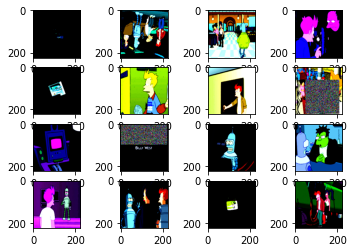

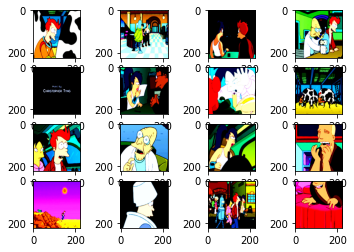

In [ ]:
sample = next(iter(train_loader))

print(f'Train Images example:')

fig, axeslist = plt.subplots(ncols=4, nrows=int(batch_size/4))
for ind,transfromed_img in enumerate(sample['image']):
    axeslist.ravel()[ind].imshow(np.clip( transfromed_img.permute(1, 2, 0),0,1), cmap=plt.gray())
    # axeslist.ravel()[ind].set_axis_off()

if(len(val_loader)>0):
    sample = next(iter(val_loader))

    print(f'Validation Images example:')

    fig, axeslist = plt.subplots(ncols=4, nrows=int(batch_size/4))
    for ind,transfromed_img in enumerate(sample['image']):
        axeslist.ravel()[ind].imshow(np.clip( transfromed_img.permute(1, 2, 0),0,1), cmap=plt.gray())
        # axeslist.ravel()[ind].set_axis_off()



In [ ]:
model = FuturamaResnet(network_type, hidden_layer, dropout_value).to(device)

using resnet152


### Train the model

In [ ]:
#|eval: false
training(model, device, None, lr_value, lr_decay, epochs, train_loader, val_loader)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch Train[1/40], Step [407/407], Loss: 1.8768
Epoch Test [1/40], Step [102/102], Loss: 1.0355
Accuracy: 0.866217315196991
Adjusting learning rate of group 0 to 8.0000e-05.
Epoch Train[2/40], Step [407/407], Loss: 1.3975
Epoch Test [2/40], Step [102/102], Loss: 0.5877
Accuracy: 0.9264705777168274
Adjusting learning rate of group 0 to 6.4000e-05.
Epoch Train[3/40], Step [407/407], Loss: 1.0815
Epoch Test [3/40], Step [102/102], Loss: 0.4535
Accuracy: 0.9505718946456909
Adjusting learning rate of group 0 to 5.1200e-05.
Epoch Train[4/40], Step [407/407], Loss: 0.9160
Epoch Test [4/40], Step [102/102], Loss: 0.3497
Accuracy: 0.9577205777168274
Adjusting learning rate of group 0 to 4.0960e-05.
Epoch Train[5/40], Step [407/407], Loss: 0.7982
Epoch Test [5/40], Step [102/102], Loss: 0.3008
Accuracy: 0.9632353186607361
Adjusting learning rate of group 0 to 3.2768e-05.
Epoch Train[6/40], Step [407/407], Loss: 0.7062
Epoch Test [6/40], Step [102

KeyboardInterrupt: 

### Create the submission for the challenge

>When we are satisfied with the hiperparameters chossen, we can generate the submission using the trained model. 

In [ ]:
#|eval: false
create_submission(
    model, sample_sub_path, test_img_path, sub_dst_path, data_mean, data_std,device
)
